In [10]:
import shap
import pandas as pd
from scipy.stats import uniform
from pygam import LogisticGAM
from scipy.stats import loguniform
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
)
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

import sys
import os
import warnings


if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

In [11]:
path = "https://raw.githubusercontent.com/nogibjj/IDS705_FinalProject_Lemur_Team/main/01_clean_data/adult_ohe.csv"

adult_ohe = pd.read_csv(path)

X = adult_ohe.drop(columns=["income"])
y = adult_ohe["income"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [20]:
y_test.shape

(9769,)

In [12]:
param_dist = {
    "lam": uniform(0, 1),  # default: 0.6
    "n_splines": list(range(5, 51)),  # default: 20
    "max_iter": list(range(50, 201)),  # default: 100
    "tol": uniform(0.0001, 0.001),  # default: 0.0001
}

clf = LogisticGAM()

random_search = RandomizedSearchCV(
    clf,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    scoring="accuracy",
    random_state=42,
)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
best_model = random_search.best_estimator_
best_params

{'lam': 0.3745401188473625,
 'max_iter': 142,
 'n_splines': 19,
 'tol': 0.0008319939418114052}

In [13]:
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
y_pred_proba = best_model.predict_proba(X_test)


auc_roc = roc_auc_score(y_test, y_pred_proba)
auc_pr = average_precision_score(y_test, y_pred_proba)


print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"AUC - ROC: {auc_roc:.3f}")
print(f"AUC - PR: {auc_pr:.3f}")

Accuracy: 0.859
Precision: 0.760
Recall: 0.609
F1 Score: 0.676
AUC - ROC: 0.913
AUC - PR: 0.791


In [14]:
def f(x):
    return best_model.predict_proba(x)  # [:, 1]


med = X_train.median().values.reshape((1, X_train.shape[1]))

explainer = shap.Explainer(f, med)
shap_values = explainer(X_test)

PermutationExplainer explainer: 9770it [49:46,  3.26it/s]                          


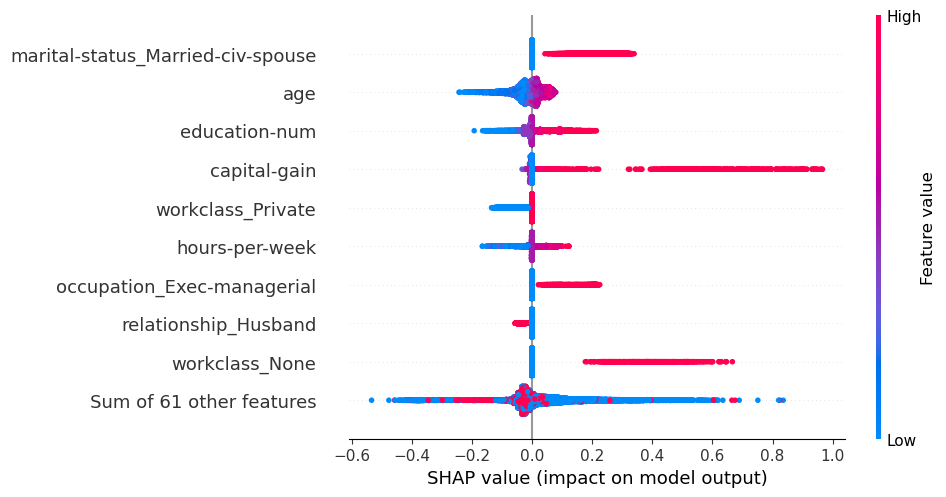

In [15]:
shap.plots.beeswarm(shap_values)

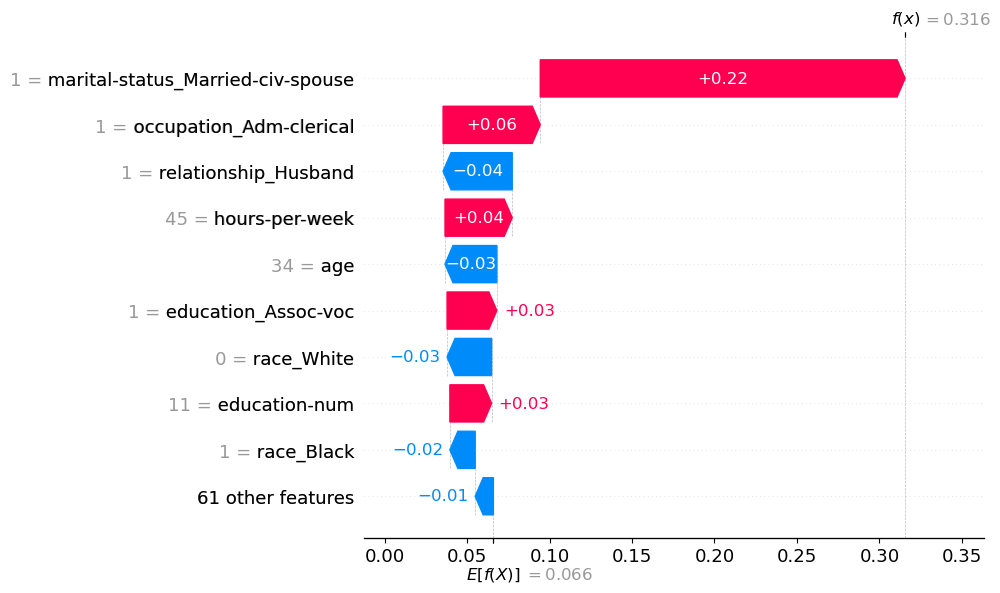

In [16]:
shap.plots.waterfall(shap_values[11])

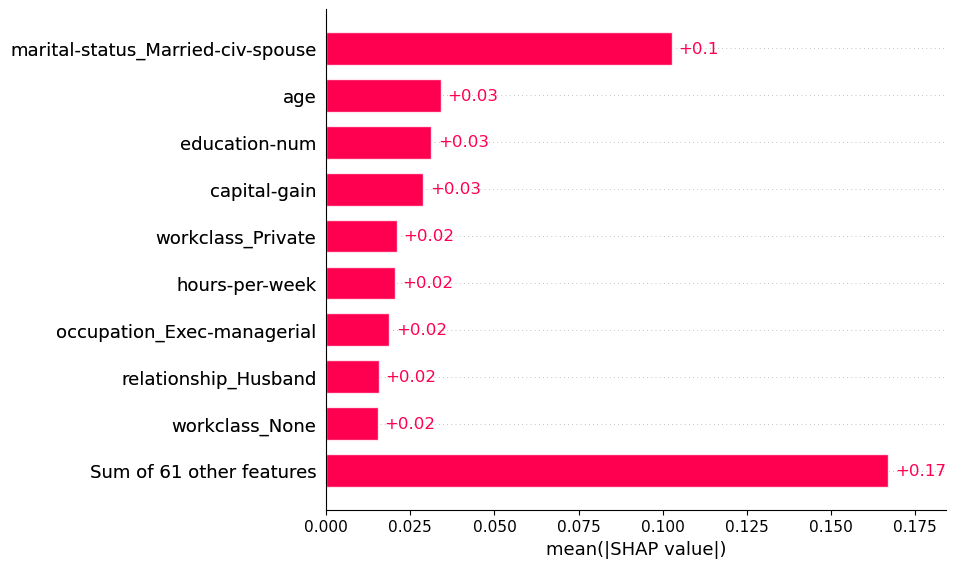

In [17]:
shap.plots.bar(shap_values)

In [ ]:
def create_submission(confidence_scores, save_path):
    """Creates an output file of submissions for Kaggle

    Parameters
    ----------
    confidence_scores : list or numpy array
        Confidence scores (from predict_proba methods from classifiers) or
        binary predictions (only recommended in cases when predict_proba is
        not available)
    save_path : string
        File path for where to save the submission file.

    Example:
    create_submission(my_confidence_scores, './data/submission.csv')

    """
    import pandas as pd

    submission = pd.DataFrame({"score": confidence_scores})
    submission.to_csv(save_path, index_label="id")

In [29]:
# submit result for AUC PR curves
results = pd.DataFrame({"score": y_pred_proba})
results.index.name = "id"
results.to_csv("../40_results/gam_prob.csv")